In [ ]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'electronic_gen_6_testing_attn'

In [34]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [6]:
all_data = all_data[(all_data['class'] == 'LETTERS') | (all_data['class'] == 'ELECTRONIC')]
all_data = all_data[all_data['after'].str.len() > 5]
all_data.sample(2)
len(all_data)

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
6474792,492378,1,LETTERS,Oper,o p e r,LETTERS,"[25, 24, 28, 35, 0]",stiftung <SAMPLE> in berlin .
6166880,469644,1,LETTERS,Hver,h v e r,LETTERS,"[45, 54, 28, 35, 0]",""" <SAMPLE> er samraethisaldur a islandi ? """


32992

In [7]:
sample_data = all_data.copy()
sample_data = sample_data.reset_index(drop=True)
del(all_data)

sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] == 'ELECTRONIC']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

In [8]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS']
2


In [9]:
sample_data.sample(2)

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
27118,612098,4,LETTERS,A&M,a and m,LETTERS,"[22, 55, 32, 0]",college station : texas <SAMPLE> university pr...
4646,112672,3,LETTERS,Ngay,n g a y,LETTERS,"[29, 53, 22, 86, 0]",vi trai tim <SAMPLE> tho thanh quynh 3 .


### Utils stuff

In [10]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


In [20]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

In [ ]:
arr = list(sample_data['after'])
arr = [s.split(' ') for s in arr]
words_after = [EOS_TOKEN, SOS_TOKEN, UNKNOWN_WORD_TOKEN, NUMBER_WORD_TOKEN, SAMPLE_WORD_TOKEN]
words_after = words_after + sorted(list(set(np.concatenate(arr))))
words_after_index = dict((c, i) for i, c in enumerate(words_after))
words_after_by_length = sorted(words_after, key=len, reverse=True)
words_after_regex = re.compile('(' + ')|('.join(words_after_by_length) + ')')

In [12]:
len(words_after)

152

chars_after = [EOS_TOKEN, SOS_TOKEN] + sorted(list(set(list(''.join(list(sample_data['after']))))))
chars_after_index = dict((c, i) for i, c in enumerate(chars_after))
''.join(chars_after)

In [13]:
def after_sentence_to_word_indexes(sentence, include_eos=True):
    reg = re.finditer(words_after_regex, sentence)
    arr = [words_after_index[s[0]] for s in reg]
    if include_eos:
        arr += [words_after_index[EOS_TOKEN]]
    return arr
tmp = after_sentence_to_word_indexes('dot d o c')
tmp
[words_after[t] for t in tmp]

[32, 26, 92, 19, 0]

['dot', 'd', 'o', 'c', '<EOS>']

In [14]:
sos_tensor = torch.zeros(1, 1, len(words_after_index))
sos_tensor[0, 0, words_after_index[SOS_TOKEN]] = 1
sos_tensor.size()
#del(onehot_sos)

# sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

torch.Size([1, 1, 152])

### Samples

In [264]:
balanced_data_length = len(sample_data)
def get_random_sample(return_last = False):
    global sample_row_last
    sample_row = balanced_data_last_sample = sample_data.iloc[random.randint(1, balanced_data_length-1)]
    if return_last:
        sample_row = sample_row_last
    else:
        sample_row_last = sample_row
    
    a_words_ind = after_sentence_to_word_indexes(sample_row['after'], include_eos=True)
    return sample_row['before'], a_words_ind, sample_row['class'], sample_row['sentence'].split(' ')
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after[i] for i in s_aft])
    print(s_class, s_bef, '->', s_aft_str, s_aft)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
    
    print(s_sentence)
    words_t = words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)
    print(words_t.size())

tmp()

In [ ]:
%%timeit
get_random_sample()

# Model functions

In [16]:
use_cuda = True

In [17]:
MAX_ATTENTION_LENGTH = 50

In [18]:
tmp = sample_data[sample_data['before'].str.len()>MAX_ATTENTION_LENGTH]
len(tmp)
tmp.sample(2)
# tmp[~tmp['before'].str.contains('/')].sample(2)

498

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
27339,616779,7,ELECTRONIC,http://www.upi.com/Audio/Year_in_Review/Events...,h t t p colon slash slash w w w dot u p i dot ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...","isbn 0 - 471 - 13340 - x . upi . com , year in..."
5497,133089,8,ELECTRONIC,http://www.natchezontheriver.com/news/2008/oct...,h t t p colon slash slash w w w dot n a t c h ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...","natchez on the river staff : dunleith , <SAMPL..."


### Encoder

In [280]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.GRU(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.GRU(chars_input_size, chars_hidden_size // 2, chars_layers,
                                 batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = hidden_words.view(1, -1)
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = hidden_chars.view(1, -1)
        
        #hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        #for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
        #    hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)

        all_outputs_chars_padded = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.chars_hidden_size)).cuda()
        att_length = min(len(all_outputs_chars[0]), MAX_ATTENTION_LENGTH-1)
        all_outputs_chars_padded[0:att_length] = all_outputs_chars[0][0:att_length]
        
        output = torch.cat((output_words, output_chars), 1)

        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, all_outputs_chars_padded

    def init_hidden(self):
        var1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1 = var1.cuda(); var2 = var2.cuda()
        return (var1, var2)
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): GRU(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): GRU(104, 128, batch_first=True, bidirectional=True)
)

In [282]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    #s_bef, s_aft, s_class, s_sentence = get_random_sample(True)
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(tmp_encoder_output, tmp_encoder_outputs), tmp = test_encoder_single_sample()
tmp
tmp_encoder_output.size()
tmp_encoder_outputs.size()
#torch.eq(encoder_output, encoder_outputs[len(tmp)]).data.all()

ISBN


'ISBN'

torch.Size([1, 384])

torch.Size([50, 256])

### Decoder

In [240]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, chars_encoded_size,
                 n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        self.emb_lin = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
                
        self.attn = nn.Linear(self.hidden_size+self.hidden_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size+chars_encoded_size, self.hidden_size)
        
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True, bidirectional=False)
        self.lin_out = nn.Linear(hidden_size, input_size)

    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.emb_lin(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        embedded = embedded[0]
                
        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidden), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        #return embedded, attn_applied
        rnn_input = torch.cat((embedded, attn_applied[0]), 1)
        
        rnn_input = self.attn_combine(rnn_input).unsqueeze(0)
        
        rnn_input = F.relu(rnn_input)
    
        
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        output = F.log_softmax(self.lin_out(output[0]))
        
        return output, hidden[0], attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after), hidden_size=tmp_encoder_output.size()[1],
                         chars_encoded_size=tmp_encoder_outputs.size()[1], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_encoder_output, tmp_encoder_outputs)
#tmp
[v.size() for v in tmp]

DecoderRNN (
  (emb_lin): Linear (152 -> 384)
  (dropout): Dropout (p = 0.1)
  (attn): Linear (768 -> 50)
  (attn_combine): Linear (640 -> 384)
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 152)
)

[torch.Size([1, 152]), torch.Size([1, 384]), torch.Size([1, 50])]

In [241]:
print(tmp[0].topk(1)[1])
print(words_after[tmp[0].topk(1)[1].data[0][0]])

Variable containing:
 132
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

twerkit


# Training etc

### Accuracy

In [376]:
def test_model_single_sample(model=None, return_more=False, sample=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    if not sample:
        sample = get_random_sample()
    s_bef, s_aft, s_class, s_sentence = sample
        
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)

    decoder_input = Variable(sos_tensor).cuda()
    decoder_hidden = encoder_output

    decoded_output = []
    decoder_attns_arr = []
    max_length = 30
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample()
tmp

('a o s l o',
 'a o s l o',
 'a o s l o',
 ('AOSLO',
  [5, 92, 113, 76, 92, 0],
  'LETTERS',
  ['<SAMPLE>',
   'compares',
   'favorably',
   'with',
   'other',
   'retinal',
   'imaging',
   'techniques',
   'as',
   'well',
   '.']))

In [286]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

ESPN           => w w w one one one one one one one one one one one one one one one one one one one one one one one one one one one || [33, 113, 100, 87, 0] 
                  ['<SAMPLE>', 'fc', '(', 'entertainment', 'and', 'sports', 'programming', 'network', '(', 'espn', ')', ')', '.']
NORAD          => w w one one one one one one one one one one one one one one one one one one one one one one one one one one one one || [87, 92, 109, 5, 26, 0] 
                  ['"', 'jb', '-', '3', 'c', 'satellite', 'details', '2004', '-', '044', 'a', '<SAMPLE>', '28470', '"', '.']


In [287]:
%%time
test_model_accuracy(decoder_rnn, test_model_single_sample, n_sample=100)

Accuracy: 0.00% (       0/     100)
CPU times: user 3.3 s, sys: 28 ms, total: 3.32 s
Wall time: 3.32 s


0.0

### Training

In [293]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
   
    decoder_hidden = encoder_output
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [297]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft_sentence)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [298]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/electronic_gen_6_testing_attn


In [301]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

    19  18% (   0m 0s)   4.053   |   0.25: http://www.flightglobal.com/pdfarchive/view/1953/1953%20-%201102.html -> s s s s s (✗: h t t p colon slash slash w w w dot f l i g h t g l o b a l dot com slash p d f a r c h i v e slash v i e w slash n i n e t e e n f i f t y t h r e e slash n i n e t e e n f i f t y t h r e e p e r c e n t t w e n t y dash p e r c e n t t w o o o n e o n e o t w o dot h t m l) 
    28  36% (   0m 0s)   4.395   |   4.89: é -> s s s (✗: e acute) 
    37  54% (   0m 0s)   4.164   |   0.09: www.avalancheinc.co.uk/finalbio.htmlhttp://www.doommantia.com/2010/05/interview-with-andy-swan-from-iroha.htmlStrong -> s s (✗: w w w dot a v a l a n c h e i n c dot c o dot u k s l a s h f i n a l b i o dot h t m l h t t p c o l o n s l a s h s l a s h w w w dot d o o m m a n t i a dot c o m s l a s h t w e n t y t e n s l a s h o f i v e s l a s h i n t e r v i e w d a s h w i t h d a s h a n d y d a s h s w a n d a s h f r o m d a s h i r o h a dot h t m l s t r o n g) 
  

In [312]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

In [313]:
train_iterations(n_iters=90000, print_every=10000)

 11000  11% (  4m 51s)   0.172   |   0.00: CEOs -> c e o's (✓) 
 21000  22% (  9m 36s)   0.240   |   0.01: APA's -> a p a's (✓) 
 31000  33% ( 14m 36s)   0.293   |   0.01: é -> e acute (✓) 
 41000  44% ( 19m 40s)   0.307   |   0.01: ALTn -> a l t n (✓) 
Saved model to data/models/electronic_gen_6_testing_attn/50000_(EncoderRNN/DecoderRNN)
Accuracy: 84.02% (    8402/   10000)
 51000  56% ( 26m 15s)   0.259   |   2.99: Pro-Football-Reference.com -> p r o d a s h a a s s a a s a a a s a i a a h a d a a a s s e e a (✗: p r o d a s h f o o t b a l l d a s h r e f e r e n c e dot c o m) (forcing)
 61000  67% ( 31m 13s)   0.357   |   0.01: ICBM -> i c b m (✓) (forcing)
 71000  78% ( 36m 12s)   0.279   |   0.01: Quoy -> q u o y (✓) 
 81000  89% ( 41m 23s)   0.431   |   2.61: OpenSecrets.orgLindsay -> o p e n n e e e e n dot e o dot e e e e e i e n dot (✗: o p e n s e c r e t s dot o r g l i n d s a y) (forcing)
 91000 100% ( 46m 32s)   0.260   |   0.01: Nahj -> n a h j (✓) (forcing)


In [314]:
train_iterations(n_iters=9000, print_every=5000)

 96000  56% (  2m 23s)   0.557   |   1.31: atrophin- -> a t s o p <EOS> i <EOS> (✗: a t r o p h i n) (forcing)
Saved model to data/models/electronic_gen_6_testing_attn/100000_(EncoderRNN/DecoderRNN)
Accuracy: 73.32% (    7332/   10000)


In [403]:
train_iterations(n_iters=50000, print_every=10000)

110000  20% (  4m 45s)   0.279   |   0.01: OROV -> o r o v (✓) 
120000  40% (  9m 43s)   0.261   |   0.13: Ilhwa -> i l h w a (✓) 
130000  60% ( 14m 41s)   0.320   |   0.11: amazon.com -> a m a z o n dot c o m (✓) 
140000  80% ( 19m 48s)   0.489   |   0.02: mRNAs -> m r n a's (✓) (forcing)
150000 100% ( 24m 46s)   0.425   |   0.21: ICTMN.com -> i c t m n dot c o m (✓) (forcing)
Saved model to data/models/electronic_gen_6_testing_attn/150000_(EncoderRNN/DecoderRNN)
Accuracy: 76.26% (    7626/   10000)


In [425]:
train_iterations(n_iters=50000, print_every=10000)

160000  20% (  4m 56s)   0.353   |   2.63: http://www.espnscrum.com/scrum/rugby/story/96890.html -> h t t p colon slash slash w w dot dot c dot slash slash slash dot slash e n slash c slash slash c i i n slash c e e slash dot c c c dot n e c c e c e c slash c e dot c slash slash e e e slash c n c dot i slash a (✗: h t t p colon slash slash w w w dot e s p n s c r u m dot com slash s c r u m slash r u g b y slash s t o r y slash n i n e s i x e i g h t n i n e o dot h t m l) (forcing)
170000  40% (  9m 38s)   0.393   |   0.02: MNLUAT -> m n l u a t (✓) 
180000  60% ( 14m 27s)   0.294   |   0.00: ISBN -> i s b n (✓) (forcing)
190000  80% ( 19m 27s)   0.317   |   0.01: DOCG -> d o c g (✓) 
200000 100% ( 24m 19s)   0.390   |   0.00: ISBN -> i s b n (✓) 
Saved model to data/models/electronic_gen_6_testing_attn/200000_(EncoderRNN/DecoderRNN)
Accuracy: 73.65% (    7365/   10000)


In [390]:
state_dict_path = 'data/models/electronic_gen_6_testing_attn/100000_'
#state_dict_path = 'data/models/electronic_gen_6_testing_attn/50000_'
decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

### Show attention

input:   GodVine.com
output:  g o d i i c o m
target:    godvinedotcom


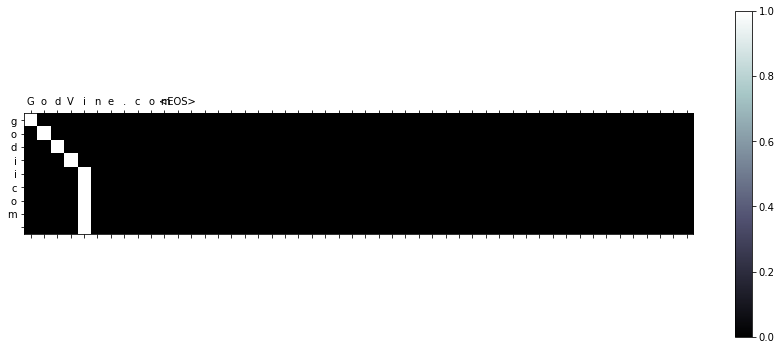

In [433]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    #ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    input_sentence = input_sentence + ['<EOS>']
    #inp_arr = ["{}\n{}".format(input_sentence[i], input_sentence[-1-i]) for i in range(len(input_sentence))]
    inp_arr = input_sentence
    ax.set_xticklabels([''] + inp_arr, rotation=0)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    global sample_row_last
    #sample_row = balanced_data_sample_row()
    sample_row = sample_data[sample_data['before'].str.len()>10].sample(1).iloc[0]
    sample_row_last = sample_row
       
    a_words_ind = after_sentence_to_word_indexes(sample_row['after'], include_eos=True)
    sample = sample_row['before'], a_words_ind, sample_row['class'], sample_row['sentence'].split(' ')

    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, 
                                                            return_more=True, sample=sample)
    print('input:  ', sample[0])
    print('output: ', ' '.join(decoded_output))
    print('target:   ', ''.join([words_after[w] for w in a_words_ind[:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)

debug_eval_sample_show_attention()

In [329]:
sample_row_last

sentence_id                                               360158
token_id                                                       3
class                                                 ELECTRONIC
before         https://www.gov.uk/government/organisations/te...
after          h t t p s colon slash slash w w w dot g o v do...
class_org                                             ELECTRONIC
a_word_ind     [45, 30, 30, 24, 17, 129, 101, 101, 52, 52, 52...
sentence                             available from : <SAMPLE> .
Name: 15512, dtype: object

In [370]:
sample_row_last = sample_data.loc[15512]
sample_row_last

sentence_id                                               360158
token_id                                                       3
class                                                 ELECTRONIC
before         https://www.gov.uk/government/organisations/te...
after          h t t p s colon slash slash w w w dot g o v do...
class_org                                             ELECTRONIC
a_word_ind     [45, 30, 30, 24, 17, 129, 101, 101, 52, 52, 52...
sentence                             available from : <SAMPLE> .
Name: 15512, dtype: object